<a href="https://colab.research.google.com/github/Abdul-AI-creator/Abdul-AI-creator/blob/main/Training_Deep_Neural_Networks_on_a_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on a GPU with PyTorch

 This tutorial covers the following topics:

 * Creating a deep neural network with hidden layers
 * Using a non-linear activation function
 * Using a GPU (when available) to speed up training
 * Experimenting with hyperparameters to improve the model

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline
#use white background for matplotlib figure
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [5]:
dataset =MNIST(root='/data',download=True ,transform=ToTensor())
dataset

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.2MB/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.26MB/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.12MB/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.38MB/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

Let's **look at a couple of images** from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

image.shape:-  torch.Size([1, 28, 28])
Label:  5


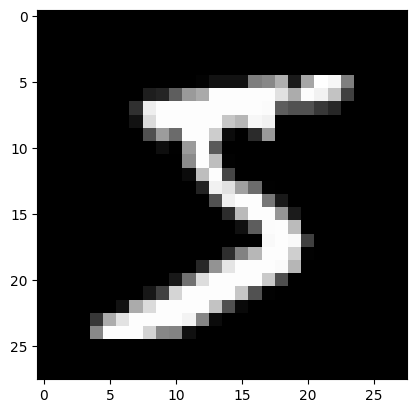

In [6]:
image ,label= dataset[0]
print('image.shape:- ' ,image.shape)
plt.imshow(image.permute(1 ,2 ,0), cmap='gray')
print('Label: ',label)

image.shape torch.Size([1, 28, 28])
Label:  9


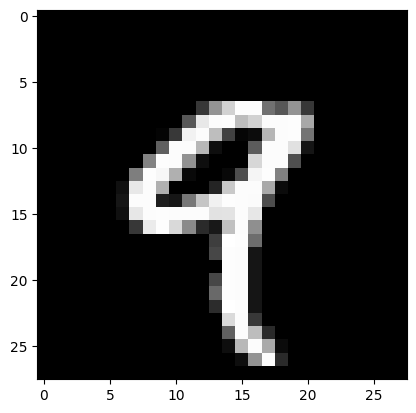

In [7]:
image ,label =dataset[4]
print('image.shape', image.shape)
plt.imshow(image.permute(1, 2, 0),cmap='gray')
print('Label: ',label)

image.shape torch.Size([1, 28, 28])
Label:  0


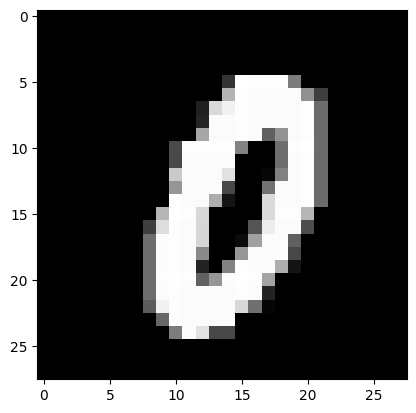

In [8]:
image ,label =dataset[34]
print('image.shape', image.shape)
plt.imshow(image.permute(1, 2, 0),cmap='gray')
print('Label: ',label)

Use `random_split` helper function to set aside 10000 images for our validation set

In [9]:
val_size =10000
train_size =len(dataset) - val_size
train_ds ,val_ds =random_split(dataset ,[train_size ,val_size])
len(train_ds) ,len(val_ds)

(50000, 10000)

In [11]:
batch_size =128    #number of samples in each batch.

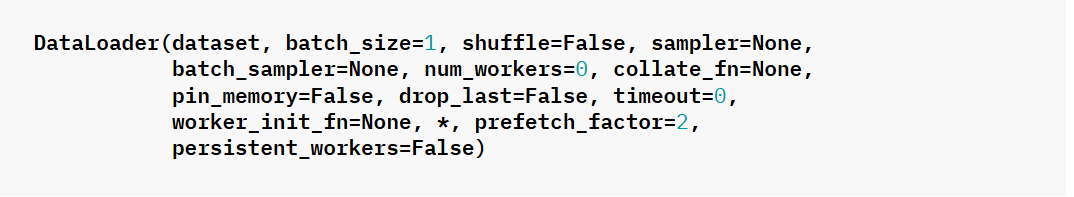

* `pin_memory:-` If True, data will be transferred to the pinned (page-locked) memory, enabling faster transfer to the GPU.Typically set to True when working with CUDA (GPU acceleration).                
* `Val_dl:-`  batch_size * 2 (typically, larger batches are used during validation since gradients aren't computed).

In [12]:
train_loader = DataLoader(train_ds ,batch_size ,shuffle=True ,num_workers=4 ,pin_memory=True)  #num _workers:-Specifies the number of subprocesses to use for data loading
val_loader =DataLoader(val_ds ,batch_size*2 ,num_workers=4 ,pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Let's visualize a batch of data in a grid using the **make_grid** function from torchvision. We'll also use the **.permute method** on the tensor to **move the channels to the last dimension, as expected by matplotlib.**

images.shape torch.Size([128, 1, 28, 28])


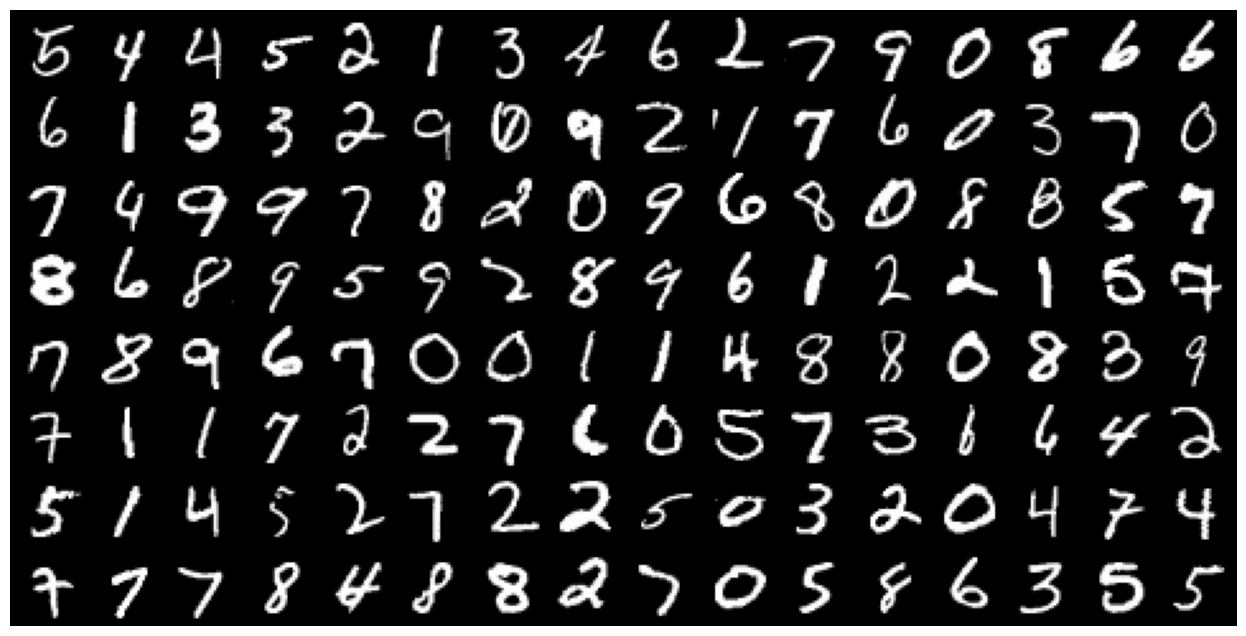

In [13]:
for images, _ in train_loader:
  print('images.shape', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images ,nrow=16).permute((1, 2, 0)))
  break

## Hidden Layers, Activation Functions and Non-Linearity

We'll **create a neural network with two layers**: a `_hidden layer_` and an `_output layer_.` Additionally, we'll use an `_activation function_` between the two layers. Let's look at a **step-by-step example** to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [14]:
for images ,labels in train_loader:
  print('Images.shape:-',images.shape)
  inputs =images.reshape(-1, 784)
  print('Inputs.shape', inputs.shape)
  break

Images.shape:- torch.Size([128, 1, 28, 28])
Inputs.shape torch.Size([128, 784])


Next, let's create a **`nn.Linear` object**, which will serve as our **_hidden_** layer. We'll **set the size** of the output from the hidden layer to **32**. This number can be **increased or decreased to change the _learning capacity_ of the model.**

In [15]:
input_size =inputs.shape[-1]
hidden_size =32

In [16]:
layer1 =nn.Linear(input_size ,hidden_size)
layer1

Linear(in_features=784, out_features=32, bias=True)

In [17]:
inputs.shape

torch.Size([128, 784])

In [18]:
layer1_output =layer1(inputs)
print('layer1_outputs.shape' ,layer1_output.shape)

layer1_outputs.shape torch.Size([128, 32])


The **image vectors of size `784`** are transformed into intermediate output **vectors of length `32`** by performing a **matrix multiplication** of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using **`torch.allclose`**.

In [19]:
layer1_outputs_direct =inputs @ layer1.weight.t() + layer1.bias
print(layer1_outputs_direct)
layer1_outputs_direct.shape

tensor([[ 0.1022,  0.1298,  0.0793,  ..., -0.2427, -0.0368,  0.3026],
        [ 0.1605, -0.2157, -0.0380,  ..., -0.1250,  0.0031,  0.0029],
        [-0.1664,  0.0103,  0.0116,  ..., -0.0658, -0.1872,  0.3810],
        ...,
        [ 0.1552, -0.1879,  0.0446,  ..., -0.0479,  0.0399,  0.1536],
        [ 0.2306, -0.3784,  0.0552,  ..., -0.3444, -0.1686,  0.1316],
        [-0.0394, -0.2391, -0.2063,  ..., -0.2711, -0.0503,  0.2736]],
       grad_fn=<AddBackward0>)


torch.Size([128, 32])

In [20]:
torch.allclose(layer1_output, layer1_outputs_direct ,1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

# ** Rectified Linear Unit (ReLU) function **

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [21]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2 ,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's **apply the activation function** to `layer1_outputs` and verify that negative values were replaced with 0.

In [22]:
relu_outputs =F.relu(layer1_output)
print('min(layer1_output)' ,torch.min(layer1_output).item())
print('min(RElU outputs)' , torch.min(relu_outputs).item())

min(layer1_output) -0.7014977335929871
min(RElU outputs) 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [23]:
output_size =10
layer2 = nn.Linear(hidden_size,output_size)
layer2

Linear(in_features=32, out_features=10, bias=True)

In [24]:
layer2_outputs =layer2(relu_outputs)
print(layer2_outputs.shape)
layer2_outputs

torch.Size([128, 10])


tensor([[-0.0923,  0.0756, -0.0204,  ...,  0.1948, -0.0562,  0.1039],
        [-0.1930,  0.0412, -0.0066,  ...,  0.1553, -0.0801,  0.1103],
        [-0.1814,  0.0373, -0.0593,  ...,  0.2282, -0.0832,  0.1476],
        ...,
        [-0.1577, -0.0471, -0.0131,  ...,  0.2176, -0.0326,  0.0269],
        [-0.2019,  0.0257,  0.0089,  ...,  0.2230, -0.0197,  0.0204],
        [-0.1321, -0.0624, -0.0485,  ...,  0.2112, -0.0056,  0.0722]],
       grad_fn=<AddmmBackward0>)

In [25]:
inputs.shape

torch.Size([128, 784])

In [26]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2844, grad_fn=<NllLossBackward0>)

Thus, our** model transforms `inputs` into `layer2_outputs`** by applying a linear transformation (using `layer1`), followed by a **non-linear activation** (using `F.relu`), followed by another linear transformation (using `layer2`). **Let's verify** this by re-computing the output using basic matrix operations.

In [27]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
outputs

tensor([[-0.0923,  0.0756, -0.0204,  ...,  0.1948, -0.0562,  0.1039],
        [-0.1930,  0.0412, -0.0066,  ...,  0.1553, -0.0801,  0.1103],
        [-0.1814,  0.0373, -0.0593,  ...,  0.2282, -0.0832,  0.1476],
        ...,
        [-0.1577, -0.0471, -0.0131,  ...,  0.2176, -0.0326,  0.0269],
        [-0.2019,  0.0257,  0.0089,  ...,  0.2230, -0.0197,  0.0204],
        [-0.1321, -0.0624, -0.0485,  ...,  0.2112, -0.0056,  0.0722]],
       grad_fn=<AddBackward0>)

In [28]:
torch.allclose(outputs ,layer2_outputs ,1e-3)

True

In [29]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias
outputs2

tensor([[-0.2443,  0.1694, -0.0434,  ...,  0.1534, -0.0152,  0.2124],
        [-0.5261,  0.2291, -0.0503,  ...,  0.1686, -0.0947,  0.1901],
        [-0.3916,  0.1282, -0.1467,  ...,  0.2717, -0.1124,  0.1813],
        ...,
        [-0.3265, -0.0585, -0.0273,  ...,  0.1453, -0.0723,  0.0268],
        [-0.4845,  0.1489, -0.0062,  ...,  0.2746,  0.0459,  0.0575],
        [-0.2861,  0.0129, -0.0703,  ...,  0.1883, -0.0145,  0.1503]],
       grad_fn=<AddBackward0>)

**create a single layer to replace the two layers**

In [30]:
combined_layer =nn.Linear(input_size ,output_size)
combined_layer.weight.data =layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [31]:
combined_layer

Linear(in_features=784, out_features=10, bias=True)

In [32]:
combined_layer.weight.data

tensor([[ 0.0023, -0.0034, -0.0009,  ..., -0.0218,  0.0065, -0.0045],
        [-0.0076, -0.0178, -0.0020,  ...,  0.0118,  0.0103,  0.0026],
        [ 0.0005,  0.0066,  0.0138,  ...,  0.0007, -0.0027, -0.0033],
        ...,
        [ 0.0063,  0.0037, -0.0156,  ...,  0.0009,  0.0009, -0.0251],
        [ 0.0246,  0.0005,  0.0075,  ..., -0.0114,  0.0058,  0.0044],
        [ 0.0041,  0.0072,  0.0053,  ..., -0.0057,  0.0007,  0.0064]])

In [33]:
combined_layer.bias.data

tensor([-0.1869,  0.0743, -0.0164, -0.1497,  0.0606, -0.1055,  0.1651,  0.1334,
        -0.1226,  0.0556])

In [34]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias
outputs3

tensor([[-0.2443,  0.1694, -0.0434,  ...,  0.1534, -0.0152,  0.2124],
        [-0.5261,  0.2291, -0.0503,  ...,  0.1686, -0.0947,  0.1901],
        [-0.3916,  0.1282, -0.1467,  ...,  0.2717, -0.1124,  0.1813],
        ...,
        [-0.3265, -0.0585, -0.0273,  ...,  0.1453, -0.0723,  0.0268],
        [-0.4845,  0.1489, -0.0062,  ...,  0.2746,  0.0459,  0.0575],
        [-0.2861,  0.0129, -0.0703,  ...,  0.1883, -0.0145,  0.1503]],
       grad_fn=<AddBackward0>)

In [35]:
torch.allclose(outputs2 ,outputs3 ,1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network.

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [36]:
class MnistModel(nn.Module):
  """Feed Forward neural network with  hidden """
  def __init__(self ,in_size ,hidden_size ,out_size):
    super().__init__()
    # hidden layer
    self.linear1 =nn.Linear(in_size ,hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size ,out_size)

  def forward(self ,xb):
    # Flatten image tensor
    xb=xb.view(xb.size(0) ,-1)

    # Get intermediate outputs using hidden layer
    out=self.linear1(xb)

    # Apply Activation Function
    out =F.relu(out)

    # Get Predictions using Output layer
    out =self.linear2(out)
    return out

  def training_step(self ,batch):
    images ,labels =batch
    out =self(images)                  # Generate Predictions
    loss =F.cross_entropy(out ,labels) # Calculate Loss
    return loss

  def validation_step(self ,batch):
    images ,labels =batch
    out =self(images)
    loss =F.cross_entropy(out, labels)
    acc = accuracy(out, labels)        # Calculate Accuracy
    return {'val_loss': loss, 'val_acc':acc}

  def validation_epoch_end(self ,outputs):
    batch_losses =[x['val_loss']  for x in outputs]
    epoch_loss =torch.stack(batch_losses).mean()         # Combined Loss
    batch_acc =[x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()            # Combined Accuracies
    return {'val_loss':epoch_loss.item() ,'val_acc':epoch_acc.item()}

  def epoch_end(self ,epoch ,result):
    print("Epoch [{}] , val_loss: {:.4f} ,val_acc: {:.4f}".format(epoch ,result['val_loss'] ,result['val_acc']))

We also need to **define an accuracy function** which calculates the accuracy of the model's prediction on an batch of inputs. It's used in **validation_step**

In [37]:
def accuracy(outputs,labels):
  _ ,preds =torch.max(outputs ,dim=1)
  return torch.tensor(torch.sum(preds ==labels).item() / len(preds))

**We'll create a model that contains a hidden layer with 32 activations.**

In [38]:
input_size =784
hidden_size=32
n_classes =10

In [39]:
model =MnistModel(input_size ,hidden_size=32 ,out_size=n_classes)
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers

In [40]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [41]:
for images ,labels in train_loader:
  output =model(images)
  loss =F.cross_entropy(outputs ,labels)
  print('Loss: ',loss.item())
  break

print('Outpus.shape ',outputs.shape)
print('Sample outputs: \n', outputs[:4].data)

Loss:  2.3148293495178223
Outpus.shape  torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.0923,  0.0756, -0.0204, -0.1611,  0.0443, -0.1504,  0.1475,  0.1948,
         -0.0562,  0.1039],
        [-0.1930,  0.0412, -0.0066, -0.1068,  0.0129, -0.1535,  0.1745,  0.1553,
         -0.0801,  0.1103],
        [-0.1814,  0.0373, -0.0593, -0.1128, -0.0451, -0.1363,  0.1224,  0.2282,
         -0.0832,  0.1476],
        [-0.2229,  0.0314, -0.0006, -0.0723, -0.0502, -0.1488,  0.1549,  0.1817,
         -0.0783,  0.1540]])


We can **check if a GPU is available** and the required NVIDIA CUDA drivers are installed using torch.cuda.is_available

In [42]:
torch.cuda.is_available()

False

Let's define a **helper function** to ensure that our code **uses the GPU if available and defaults to using the CPU if it isn't.**

In [43]:
def get_default_device():
  # Pick GPU if available
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [44]:
device =get_default_device()
device

device(type='cpu')

define a function that can move data and model to a chosen device

In [45]:
def to_device(data ,device):
  # move tensors to chosen device
  if isinstance(data ,(list ,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device ,non_blocking=True)

In [46]:
for images, labels in train_loader:
  print(images.shape)
  images =to_device(images ,device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu


Finally, we `define` a **DeviceDataLoader** class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an __iter__ method to retrieve batches of data and an __len__ method to get the number of batches.

In [47]:
class DeviceDataLoader():
  # Wrap data loader to move data to device
  def __init__(self,dl ,device):
    self.dl =dl
    self.device=device

  def __iter__(self):
    # Yield a batch of data after moving it ito device
    for b in self.dl:
      yield to_device(b ,self.device)

  def __len__(self):
    # number of batches
    return len(self.dl)

The **yield** `keyword in Python` is used to **create a generator function** that can be **used within a for loop**

In [48]:
def some_numbers():
  yield 10
  yield 20
  yield 30

for value in some_numbers():
  print(value)

10
20
30


**wrap our data loaders using DeviceDataLoader.**

In [49]:
train_loader =DeviceDataLoader(train_loader ,device)
val_loader = DeviceDataLoader(val_loader ,device)

Tensors **moved to the GPU** have a device property which includes that word cuda. Let's verify this by looking at a batch of data from valid_dl.

In [50]:
for xb ,yb in val_loader:
  print('xb.device: ',xb.device)
  print('yb:',yb)
  break

xb.device:  cpu
yb: tensor([0, 6, 5, 3, 4, 7, 2, 2, 1, 6, 4, 1, 2, 8, 4, 1, 0, 6, 1, 2, 1, 2, 6, 9,
        0, 5, 8, 2, 2, 3, 0, 4, 0, 2, 2, 5, 7, 3, 6, 2, 6, 3, 7, 2, 5, 0, 4, 4,
        7, 5, 0, 2, 3, 8, 8, 1, 9, 6, 7, 8, 3, 3, 4, 2, 9, 2, 2, 2, 8, 7, 0, 9,
        3, 8, 5, 5, 6, 9, 9, 1, 4, 2, 6, 3, 0, 4, 7, 2, 9, 0, 7, 6, 4, 2, 6, 7,
        1, 9, 0, 9, 9, 6, 9, 9, 7, 4, 9, 7, 8, 8, 9, 0, 9, 2, 4, 2, 2, 9, 1, 6,
        5, 2, 3, 6, 4, 4, 3, 8, 2, 5, 8, 8, 4, 3, 8, 3, 8, 1, 6, 3, 0, 9, 1, 5,
        5, 2, 2, 7, 1, 8, 7, 7, 0, 1, 0, 5, 4, 4, 1, 5, 3, 7, 7, 1, 5, 6, 1, 1,
        0, 0, 5, 3, 0, 9, 8, 3, 4, 9, 8, 7, 3, 1, 7, 6, 4, 7, 4, 1, 4, 8, 4, 1,
        9, 9, 5, 4, 7, 9, 4, 7, 0, 4, 9, 0, 5, 1, 2, 1, 6, 4, 2, 7, 4, 8, 2, 3,
        6, 4, 7, 4, 3, 8, 9, 3, 9, 7, 6, 6, 8, 0, 2, 9, 5, 7, 8, 0, 2, 3, 8, 8,
        4, 5, 3, 8, 4, 2, 4, 0, 0, 1, 6, 3, 7, 3, 5, 8])


## Training the Model

**We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.**  

In [51]:
def evaluate(model, val_loader):
  # Evaluate the model's performance on the validation set
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epoch ,lr , model ,train_loader, val_loader ,opt_func=torch.optim.SGD):
  # train model using Gradient Descent
  history =[]
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epoch):
    # Training phase
    for batch in train_loader:
      loss =model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Phase
    result =evaluate(model ,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history



Before we train the model, **we need to ensure** that the data and the model's parameters (weights and biases) are on the **same device (CPU or GPU)**. We can reuse the to_device function to move the model's parameters to the right device.

In [52]:
# Model(GPU)
model =MnistModel(input_size ,hidden_size =hidden_size ,out_size=n_classes)
to_device(model ,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

model performs on the validation set with the initial set of weights and biases

In [53]:
history =[evaluate(model ,val_loader)]
history

[{'val_loss': 2.305966854095459, 'val_acc': 0.07626952975988388}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [54]:
history += fit(6, 0.3, model ,train_loader ,val_loader)

Epoch [0] , val_loss: 0.2903 ,val_acc: 0.9088
Epoch [1] , val_loss: 0.1978 ,val_acc: 0.9420
Epoch [2] , val_loss: 0.1695 ,val_acc: 0.9499
Epoch [3] , val_loss: 0.1521 ,val_acc: 0.9531
Epoch [4] , val_loss: 0.1514 ,val_acc: 0.9580
Epoch [5] , val_loss: 0.1306 ,val_acc: 0.9608


In [65]:
history += fit(6, 0.1, model ,train_loader ,val_loader)

Epoch [0] , val_loss: 0.1223 ,val_acc: 0.9660
Epoch [1] , val_loss: 0.1200 ,val_acc: 0.9674
Epoch [2] , val_loss: 0.1203 ,val_acc: 0.9678
Epoch [3] , val_loss: 0.1206 ,val_acc: 0.9671
Epoch [4] , val_loss: 0.1232 ,val_acc: 0.9670
Epoch [5] , val_loss: 0.1223 ,val_acc: 0.9675


**plot the losses & accuracies to study how the model improves over time.**

Text(0.5, 1.0, 'Loss vs No of epoch')

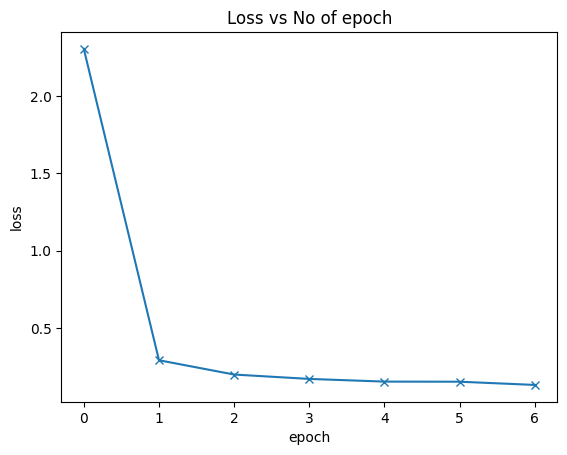

In [55]:
losses =[x['val_loss'] for x in history]
plt.plot(losses ,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss vs No of epoch")

Text(0.5, 1.0, 'Accuracies vs No of epochs')

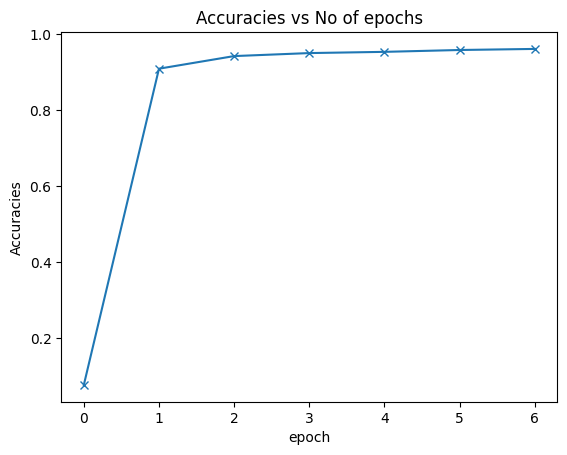

In [56]:
accuracies =[x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('Accuracies')
plt.title('Accuracies vs No of epochs')

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [58]:
# define test dataset
test_dataset = MNIST(root='/data' ,train=False ,transform =ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: ToTensor()

define a **helper function predict_image**, which returns the predicted label for a single image tensor

In [59]:
def predict_image(img ,model):
  xb =to_device(img.unsqueeze(0) ,device)
  yb =model(xb)
  _ ,preds =torch.max(yb ,dim=1)
  return preds[0].item()

Label 7 Predicted 7


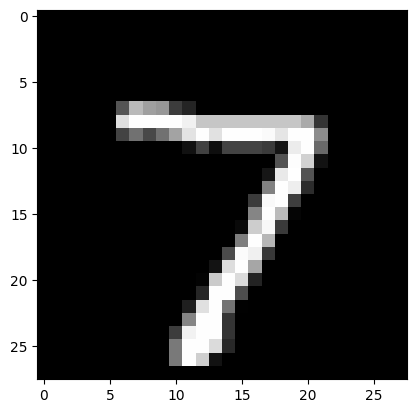

In [60]:
img ,label =test_dataset[0]
plt.imshow(img[0] ,cmap='gray')
print('Label',label ,'Predicted',predict_image(img ,model))

Label 9 Predicted 9


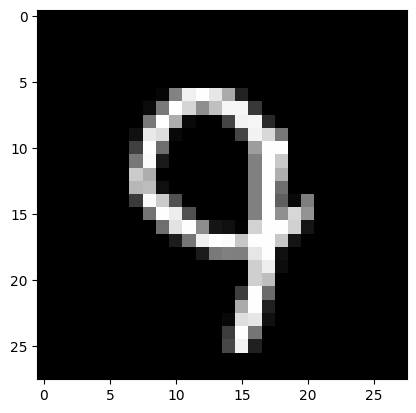

In [62]:
img ,label =test_dataset[999]
plt.imshow(img[0] ,cmap='gray')
print('Label',label ,'Predicted',predict_image(img,model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [63]:
test_loader =DeviceDataLoader(DataLoader(test_dataset,batch_size=256),device)
result = evaluate(model ,test_loader)
result

{'val_loss': 0.1261790692806244, 'val_acc': 0.963085949420929}